In [1]:
import os
import torch
import pickle 
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider
from matplotlib import colors
from matplotlib.colors import ListedColormap
from tqdm import tqdm
plt.style.use('dark_background')


In [2]:
experiment = "split_20231212"

In [3]:
def open_df(data,experiment):
    df = pd.read_csv(experiment + "/Automation_out/"+data+"_spots.csv",encoding='cp1252')
    df = df[3:]
    df = df.astype({
            "ID" : int,
            "TRACK_ID" : int, 
            "POSITION_X" : float,
            "POSITION_Y" : float,
            "POSITION_Z" : float,
            "POSITION_T" : float,
            "FRAME" : int,
            "MIN_INTENSITY_CH1" : float,
            "MAX_INTENSITY_CH1" : float,
            "MEDIAN_INTENSITY_CH1" : float,
            "TOTAL_INTENSITY_CH1" : float,
            "STD_INTENSITY_CH1" : float,
            "CONTRAST_CH1" : float,
            "SNR_CH1" : float
            })
    return df


def get_filtered_ids_len(df,N=100):
    ids, len_ids = np.unique(df["TRACK_ID"].to_numpy(),return_counts=True)
    keep = np.ones(len(ids),dtype=bool)
    for i in range(len(ids)):
        keep[i] = (len_ids[i]>=N) and (len(np.unique(df[df["TRACK_ID"]==ids[i]]["FRAME"].to_numpy()))>=N)
    return ids[keep], len_ids[keep]

def compute_traj(id,df): 
    # frames = np.sort(df[df["TRACK_ID"]==id]["FRAME"].to_numpy())
    frames = np.unique(df[df["TRACK_ID"]==id]["FRAME"].to_numpy())
    T = len(frames)
    pos = np.zeros((T,3))
    intensity = np.zeros(T)
    df_id = df[df["TRACK_ID"]==id]
    for t in range(T):
        pos[t,0] = df_id[df_id["FRAME"]==frames[t]]["POSITION_X"].values[0]
        pos[t,1] = df_id[df_id["FRAME"]==frames[t]]["POSITION_Y"].values[0]
        pos[t,2] = df_id[df_id["FRAME"]==frames[t]]["POSITION_Z"].values[0]
        intensity[t] = df_id[df_id["FRAME"]==frames[t]]["TOTAL_INTENSITY_CH1"].values[0]
    return frames, pos, intensity

def df_to_traj(data,experiment,N=100):
    df = open_df(data,experiment)
    ids, len_ids = get_filtered_ids_len(df,N=N)
    trajs = []
    for id in tqdm(ids):
        trajs.append(compute_traj(id,df))
    return trajs

def construct_cmap(cell_type):
    if cell_type=="Proximal":
        # cmap_base = pl.cm.Purples
        cmap_base = colors.LinearSegmentedColormap.from_list("magenta", ["m","m"], N=1000)
    elif cell_type=="Distal":
        # cmap_base = pl.cm.Greens
        cmap_base = colors.LinearSegmentedColormap.from_list("magenta", ["g","g"], N=1000)
    else:
        cmap_base = pl.cm.Blues
    # Get the colormap colors
    cmap = cmap_base(np.arange(cmap_base.N))
    # Set alpha
    cmap[:,-1] = np.linspace(0, 1, cmap_base.N)**2
    # Create new colormap
    cmap = ListedColormap(cmap)
    return cmap

def big_table_frame(trajs):
    N = len(trajs)
    T = max([max(traj[0]) for traj in trajs])
    big_table = -np.ones((T+1,N,3))
    for n in range(N):
        big_table[trajs[n][0],n,0] = trajs[n][1][:,0]
        big_table[trajs[n][0],n,1] = trajs[n][1][:,1]
        log_intensity = np.log10(trajs[n][2])
        log_intensity -= log_intensity.min()
        log_intensity *= 0.9/log_intensity.max()
        log_intensity += 0.09
        big_table[trajs[n][0],n,2] = log_intensity
    return big_table 
    

In [4]:
def sample_grid(n, dim=2,dtype=torch.float32,device="cpu"):
    grid_points = torch.linspace(0,1,n,dtype=dtype,device=device)
    grid_points = torch.stack(
        torch.meshgrid((grid_points,) * dim, indexing="ij"), dim=-1
    )
    grid_points = grid_points.reshape(-1, dim)
    return grid_points

N = 512
y_grid = sample_grid(N)
R = 0.05

def neighbours_grid(i,y_grid,R):
    yi = y_grid[i,:].reshape((1,2))
    return (((yi - y_grid)**2).sum(1) <= R**2).float().squeeze()

def open_data(data_dir,N=512):
    T = len([name for name in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, name))])
    data = torch.zeros((N,N,T))
    for t in range(1,T+1):
        with open(data_dir + "data_" + str(t) + ".pkl", 'rb') as file:
            data[:,:,t-1] = pickle.load(file)
    return data

def smooth_max(data,y_grid,R):
    N = data.shape[0]
    T = data.shape[2]
    data_max = torch.max(data.reshape((N*N,T)),dim=0)
    ngh_max = neighbours_grid(data_max[1][-1].item(),y_grid,R).bool()
    smooth_max = data.reshape((N*N,T))[ngh_max,:].sum(0) * (1/N)**2
    return data_max[1][-1].item(), smooth_max




In [5]:
all_stuff_proximal = []
cell_type = "Proximal"

for k in range(1,10):
    data = "FWF00" + str(k)
    trajs = df_to_traj(data + "_" + cell_type, experiment,N=50)

    data_dir = experiment+"_" + data + "_smooth/"+cell_type+"/data/"
    df = open_data(data_dir,N=N)
    index, smax = smooth_max(df,y_grid,R)
    max_x = y_grid[index,0].item() * 1300 
    max_y = y_grid[index,1].item() * 1300

    big_table = big_table_frame(trajs)[100:,:,:]
    dist0 = []
    dist1 = []
    align = []
    direct = []
    msd2 = []
    all_angles = []
    all_cos = []
    all_dist0 = []
    max_np = np.array([max_x,max_y])
    for n in range(big_table.shape[1]):
        traj = big_table[:,n,:]
        traj = traj[traj[:,0]>=0]
        if len(traj)>10:
            traj0 = traj[0,:2]
            traj1 = traj[-1,:2]
            dist0.append(math.sqrt((traj0[0].item() - max_x)**2 + (traj0[1].item() - max_y)**2))
            dist1.append(math.sqrt((traj1[0].item() - max_x)**2 + (traj1[1].item() - max_y)**2))
            u01 = (traj1 - traj0)/np.linalg.norm(traj1 - traj0)
            u0m = (max_np - traj0)/np.linalg.norm(max_np - traj0)
            align.append((u01*u0m).sum().item())
            u = traj[:,:2] - traj0.reshape((1,2))
            u01_p = np.array([-u01[1],u01[0]]).reshape((1,2))
            u0m_p = np.array([-u0m[1],u0m[0]]).reshape((1,2))
            direct.append(np.abs((u * u0m_p).sum(1)).mean())
            msd2.append((u*u).sum(1).mean())
        
        for t_traj in range(len(traj[:,0])-1):
            traj0 = traj[t_traj,:2]
            traj1 = traj[t_traj+1,:2]
            if np.linalg.norm(traj1 - traj0)>0.001:
                all_dist0.append(math.sqrt((traj0[0].item() - max_x)**2 + (traj0[1].item() - max_y)**2))
                u01 = (traj1 - traj0)/np.linalg.norm(traj1 - traj0)
                u0m = (max_np - traj0)/np.linalg.norm(max_np - traj0)
                all_cos.append((u01*u0m).sum().item())
                all_angles.append(np.math.atan2(np.linalg.det([u01,u0m]),np.dot(u01,u0m)))

    dist0 = np.array(dist0)
    dist1 = np.array(dist1)
    align = np.array(align)
    direct = np.array(direct)
    msd2 = np.array(msd2)
    all_cos = np.array(all_cos)
    all_angles = np.array(all_angles)
    
    all_stuff_proximal.append((dist0,all_angles))

dist0_all_proximal = np.array([])
angles_all_proximal = np.array([])

for stuff in all_stuff_proximal:
    dist0_all_proximal = np.concatenate((dist0_all_proximal,stuff[0]))
    angles_all_proximal = np.concatenate((angles_all_proximal,stuff[1]))



/var/folders/q_/7gz310cd4n1_v1xcnv2_qdbm0000gn/T/ipykernel_22761/2542383017.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(experiment + "/Automation_out/"+data+"_spots.csv",encoding='cp1252')
100%|██████████| 881/881 [01:12<00:00, 12.23it/s]


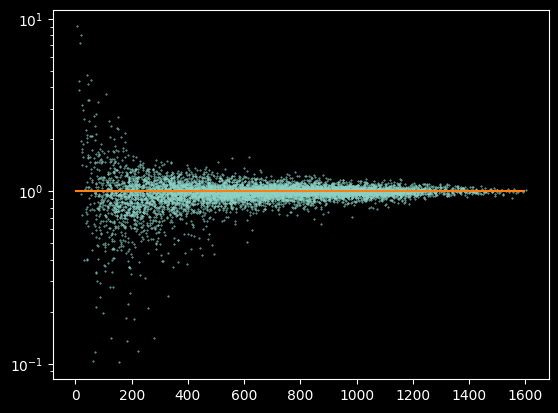

In [ ]:
# plt.plot(dist0_all_proximal,dist1_all_proximal/dist0_all_proximal,'.',markersize=0.8)
# plt.hlines(y=1,xmin=0,xmax=1600,color="tab:orange")
# plt.yscale('log')


nb_bin = 100
bins = np.linspace(0,1600,nb_bin+1)
histo_proximal = np.zeros(nb_bin)
in_logs = []
signs = []
for k in range(nb_bin):
    in_bin = (dist0_all_proximal>=bins[k])&(dist0_all_proximal<bins[k+1])
    # in_log = np.log10(dist1_all[in_bin]/dist0_all[in_bin])
    ang = angles_all_proximal[in_bin]
    # print(ang)
    av_vec = np.c_[np.cos(ang),np.sin(ang)].sum(0)/len(ang)
    av_ang = math.atan2(av_vec[1],av_vec[0])
    # histo[k] = (in_log>0).sum()/len(in_log)
    histo_proximal[k] = np.cos(av_ang)
    # in_logs.append(in_log)
    # signs.append(np.sign(in_log))
plt.plot(histo_proximal,'*')

# plt.boxplot(in_logs,showfliers=False,showmeans=True)

# plt.boxplot(signs,showfliers=False,showmeans=True)

In [ ]:
all_stuff_distal = []
cell_type = "Distal"

for k in range(1,10):
    data = "FWF00" + str(k)
    trajs = df_to_traj(data + "_" + cell_type, experiment,N=50)

    data_dir = experiment+"_" + data + "_smooth/"+cell_type+"/data/"
    df = open_data(data_dir,N=N)
    index, smax = smooth_max(df,y_grid,R)
    max_x = y_grid[index,0].item() * 1300 
    max_y = y_grid[index,1].item() * 1300

    big_table = big_table_frame(trajs)[100:,:,:]
    dist0 = []
    dist1 = []
    align = []
    direct = []
    msd2 = []
    all_angles = []
    all_cos = []
    all_dist0 = []
    max_np = np.array([max_x,max_y])
    for n in range(big_table.shape[1]):
        traj = big_table[:,n,:]
        traj = traj[traj[:,0]>=0]
        if len(traj)>10:
            traj0 = traj[0,:2]
            traj1 = traj[-1,:2]
            dist0.append(math.sqrt((traj0[0].item() - max_x)**2 + (traj0[1].item() - max_y)**2))
            dist1.append(math.sqrt((traj1[0].item() - max_x)**2 + (traj1[1].item() - max_y)**2))
            u01 = (traj1 - traj0)/np.linalg.norm(traj1 - traj0)
            u0m = (max_np - traj0)/np.linalg.norm(max_np - traj0)
            align.append((u01*u0m).sum().item())
            u = traj[:,:2] - traj0.reshape((1,2))
            u01_p = np.array([-u01[1],u01[0]]).reshape((1,2))
            u0m_p = np.array([-u0m[1],u0m[0]]).reshape((1,2))
            direct.append(np.abs((u * u0m_p).sum(1)).mean())
            msd2.append((u*u).sum(1).mean())
        
        for t_traj in range(len(traj[:,0])-1):
            traj0 = traj[t_traj,:2]
            traj1 = traj[t_traj+1,:2]
            if np.linalg.norm(traj1 - traj0)>0.001:
                all_dist0.append(math.sqrt((traj0[0].item() - max_x)**2 + (traj0[1].item() - max_y)**2))
                u01 = (traj1 - traj0)/np.linalg.norm(traj1 - traj0)
                u0m = (max_np - traj0)/np.linalg.norm(max_np - traj0)
                all_cos.append((u01*u0m).sum().item())
                all_angles.append(np.math.atan2(np.linalg.det([u01,u0m]),np.dot(u01,u0m)))

    dist0 = np.array(dist0)
    dist1 = np.array(dist1)
    align = np.array(align)
    direct = np.array(direct)
    msd2 = np.array(msd2)
    all_cos = np.array(all_cos)
    all_angles = np.array(all_angles)
    
    all_stuff_distal.append((dist0,all_angles))

dist0_all_distal = np.array([])
angles_all_distal = np.array([])

for stuff in all_stuff_distal:
    dist0_all_distal = np.concatenate((dist0_all_distal,stuff[0]))
    angles_all_distal = np.concatenate((angles_all_distal,stuff[1]))



/var/folders/q_/7gz310cd4n1_v1xcnv2_qdbm0000gn/T/ipykernel_29893/2542383017.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(experiment + "/Automation_out/"+data+"_spots.csv",encoding='cp1252')
100%|██████████| 901/901 [01:25<00:00, 10.50it/s]
/var/folders/q_/7gz310cd4n1_v1xcnv2_qdbm0000gn/T/ipykernel_29893/2542383017.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(experiment + "/Automation_out/"+data+"_spots.csv",encoding='cp1252')
100%|██████████| 949/949 [01:31<00:00, 10.33it/s]
/var/folders/q_/7gz310cd4n1_v1xcnv2_qdbm0000gn/T/ipykernel_29893/1366928609.py:29: RuntimeWarning: invalid value encountered in divide
  u01 = (traj1 - traj0)/np.linalg.norm(traj1 - traj0)
/var/folders/q_/7gz310cd4n1_v1xcnv2_qdbm0000gn/T/ipykernel_29893/2542383017.py:

In [ ]:
# plt.plot(dist0_all_proximal,dist1_all_proximal/dist0_all_proximal,'.',markersize=0.8)
# plt.hlines(y=1,xmin=0,xmax=1600,color="tab:orange")
# plt.yscale('log')


nb_bin = 100
bins = np.linspace(0,1600,nb_bin+1)
histo_distal = np.zeros(nb_bin)
in_logs = []
signs = []
for k in range(nb_bin):
    in_bin = (dist0_all_distal>=bins[k])&(dist0_all_distal<bins[k+1])
    # in_log = np.log10(dist1_all[in_bin]/dist0_all[in_bin])
    ang = angles_all_distal[in_bin]
    # print(ang)
    av_vec = np.c_[np.cos(ang),np.sin(ang)].sum(0)/len(ang)
    av_ang = math.atan2(av_vec[1],av_vec[0])
    # histo[k] = (in_log>0).sum()/len(in_log)
    histo_distal[k] = np.cos(av_ang)
    # in_logs.append(in_log)
    # signs.append(np.sign(in_log))
plt.plot(histo_distal,'*')

# plt.boxplot(in_logs,showfliers=False,showmeans=True)

# plt.boxplot(signs,showfliers=False,showmeans=True)

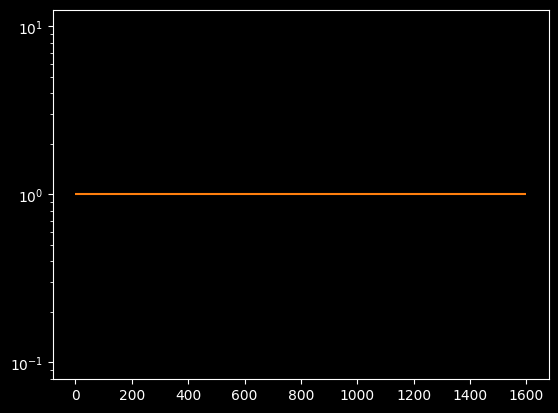

In [ ]:
plt.plot(dist0_all_distal,dist1_all_distal/dist0_all_distal,'.',markersize=0.8)
plt.hlines(y=1,xmin=0,xmax=1600,color="tab:orange")
plt.yscale('log')


In [ ]:
# nb_bin = 40
# bins = np.linspace(0,1600,nb_bin+1)
# histo = np.zeros(nb_bin)
# in_logs = []
# signs = []
# for k in range(nb_bin):
#     in_bin = (dist0_all>=bins[k])&(dist0_all<bins[k+1])
#     in_log = np.log10(dist1_all[in_bin]/dist0_all[in_bin])
#     # histo[k] = (in_log>0).sum()/len(in_log)
#     histo[k] = in_log.mean()
#     in_logs.append(in_log)
#     signs.append(np.sign(in_log))
# # plt.plot(histo,'*')

# # plt.boxplot(in_logs,showfliers=False,showmeans=True)

# plt.boxplot(signs,showfliers=False,showmeans=True)